In [11]:
# Block 1: Imports and Setup
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
# Block 2: Configuration
def get_data_directory():
    """Find the data directory dynamically"""
    possible_paths = [
        "data/new_processed_reset",
        "./data/new_processed_reset", 
        "../data/new_processed_reset",
        "data",
        "./data",
        "../data",
        "D:/Research Assistant work/Github Organization/ml models/ml_models/PhysicsGuidedNeuralNetwork/data/new_processed_reset"
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Found data directory: {path}")
            return path
    
    # If no directory found, ask user to specify
    print("Data directory not found. Please specify the path to your data directory:")
    user_path = input("Enter data directory path: ").strip()
    if os.path.exists(user_path):
        return user_path
    else:
        raise ValueError(f"Specified data directory {user_path} does not exist!")

DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# File mapping dictionaries
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"

In [13]:
# Block 3: Data Loading Functions
def parse_filename_params(filename):
    """Parse filename to extract thermal parameters"""
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw = int(m.group(3))
    surf_raw = int(m.group(4))
    t = int(m.group(5))

    h = h_map.get(h_raw, h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw, abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, filename, min_time=0):
    """Load and process individual CSV file"""
    try:
        df = pd.read_csv(path, encoding="utf-8-sig")
        df = df[df["Time"] >= min_time].copy()
        
        # Drop unwanted columns
        df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], 
                inplace=True, errors='ignore')
        
        # Add parameters
        df["h"] = h
        df["flux"] = flux
        df["abs"] = abs_val
        df["surf"] = surf
        df["filename"] = filename
        
        return df.iloc[1:] if len(df) > 1 else df
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return pd.DataFrame()

def load_data(data_dir, h_filter=None, min_time=0):
    """Load and combine all data files"""
    dataframes = []
    
    if not os.path.exists(data_dir):
        raise ValueError(f"Data directory {data_dir} does not exist!")
    
    print(f"Loading data from: {data_dir}")
    
    csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
    if not csv_files:
        raise ValueError("No CSV files found in the data directory!")
    
    for fname in csv_files:
        params = parse_filename_params(fname)
        if params is None or params[3] is None:
            print(f"Skipping (unmatched): {fname}")
            continue

        # Apply h filter if specified
        if h_filter is not None:
            h_val = params[0]
            if h_val != h_filter:
                print(f"Skipping (not h={h_filter}): {fname}")
                continue

        path = os.path.join(data_dir, fname)
        try:
            df = load_and_process_file(path, *params[:4], filename=fname, min_time=min_time)
            if not df.empty:
                dataframes.append(df)
                print(f"Loaded: {fname} ({len(df)} rows)")
        except Exception as e:
            print(f"Error loading {fname}: {e}")
    
    if not dataframes:
        raise ValueError("No valid data files found after processing!")
    
    data = pd.concat(dataframes, ignore_index=True)
    print(f"\nTotal data loaded: {len(data)} rows, {len(data.columns)} columns")
    return data

In [14]:
# Block 4: Model Architecture
class EnhancedThermalNet(nn.Module):
    """Enhanced thermal neural network with attention and residual connections"""
    def __init__(self, input_size, output_size, hidden_dims=[512, 256, 256, 128], dropout_rate=0.3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # Input processing
        self.input_layer = nn.Linear(input_size, hidden_dims[0])
        self.input_norm = nn.LayerNorm(hidden_dims[0])
        
        # Feature attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(input_size, max(1, input_size // 2)),
            nn.ReLU(),
            nn.Linear(max(1, input_size // 2), input_size),
            nn.Sigmoid()
        )
        
        # Hidden layers with residual connections
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.residual_projections = nn.ModuleList()
        
        for i in range(len(hidden_dims) - 1):
            layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            norm = nn.LayerNorm(hidden_dims[i + 1])
            
            if hidden_dims[i] != hidden_dims[i + 1]:
                residual_proj = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            else:
                residual_proj = nn.Identity()
            
            self.layers.append(layer)
            self.norms.append(norm)
            self.residual_projections.append(residual_proj)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dims[-1], output_size)
        
        # Activation and regularization
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Apply attention to input features
        attention_weights = self.attention(x)
        x_attended = x * attention_weights
        
        # Input processing
        x = self.activation(self.input_norm(self.input_layer(x_attended)))
        x = self.dropout(x)
        
        # Forward through hidden layers with residual connections
        for i, (layer, norm, residual_proj) in enumerate(zip(self.layers, self.norms, self.residual_projections)):
            residual = residual_proj(x)
            x = layer(x)
            x = norm(x)
            x = self.activation(x)
            x = x + residual
            x = self.dropout(x)
        
        # Output layer
        output = self.output_layer(x)
        return output

In [15]:
class PhysicsInformedLoss(nn.Module):
    """Physics-informed loss function with energy conservation constraint"""
    def __init__(self, smoothness_weight=0.001, gradient_weight=0.0001, physics_weight=0.01):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.smoothness_weight = smoothness_weight
        self.gradient_weight = gradient_weight
        self.physics_weight = physics_weight
        
        # Physical constants
        self.r = 2.0375 * 0.0254  # Convert inches to meters
        self.A_rec = np.pi * (self.r ** 2)  # Receiver area
        self.rho = 1836.31  # Density (kg/m³)
        self.cp = 1512  # Specific heat capacity (J/kg·K)
        
        # Convert to tensors for GPU compatibility
        self.A_rec_tensor = None
        self.rho_tensor = None
        self.cp_tensor = None
    
    def _init_tensors(self, device):
        """Initialize tensors on the correct device"""
        if self.A_rec_tensor is None:
            self.A_rec_tensor = torch.tensor(self.A_rec, device=device, dtype=torch.float32)
            self.rho_tensor = torch.tensor(self.rho, device=device, dtype=torch.float32)
            self.cp_tensor = torch.tensor(self.cp, device=device, dtype=torch.float32)
    
    def compute_physics_loss(self, predictions, targets, inputs):
        """
        Compute physics-informed loss based on energy conservation
        
        Args:
            predictions: Model predictions (batch_size, num_sensors)
            targets: Target temperatures (batch_size, num_sensors)
            inputs: Input features (batch_size, input_dim)
                   Expected to contain: [Time_norm, Time², Time³, Time_sin, Time_cos, 
                                       h, flux, abs, surf, flux_abs_interaction, h_flux_interaction, 
                                       theoretical_temps...]
        """
        device = predictions.device
        self._init_tensors(device)
        
        batch_size = predictions.shape[0]
        
        # Extract relevant features from inputs
        # Based on your preprocessing, the order should be:
        # [Time_norm, Time², Time³, Time_sin, Time_cos, h, flux, abs, surf, flux_abs_interaction, h_flux_interaction, theoretical_temps...]
        
        try:
            # Extract flux and h from inputs
            flux = inputs[:, 6]  # flux is at index 6
            h = inputs[:, 5]     # h is at index 5
            
            # Calculate incoming energy
            # incoming_energy = q0 * A_rec = flux * A_rec
            incoming_energy = flux * self.A_rec_tensor  # Shape: (batch_size,)
            
            # Calculate mass for each batch
            # mass = rho * h * pi * r^2 = rho * h * A_rec
            mass = self.rho_tensor * h * self.A_rec_tensor  # Shape: (batch_size,)
            
            # For physics loss, we need to compute temperature derivatives
            # Since we don't have explicit time derivatives in batch training,
            # we'll approximate using the difference between predicted and target temperatures
            # This represents the temperature change that should be consistent with energy balance
            
            # Average temperature change across all sensors
            temp_change = torch.mean(predictions - targets, dim=1)  # Shape: (batch_size,)
            
            # Assume unit time step (dt = 1) for simplification
            # In practice, you might want to pass actual time differences
            dt = torch.ones_like(temp_change)
            
            # Calculate total energy stored
            # total_energy_stored = mass * cp * (Temp_final - Temp_initial) / (time_final - time_initial)
            # Here we approximate with: mass * cp * temp_change / dt
            total_energy_stored = mass * self.cp_tensor * temp_change / dt  # Shape: (batch_size,)
            
            # Physics constraint: incoming_energy should equal total_energy_stored
            # Physics loss = |incoming_energy - total_energy_stored|
            physics_loss = torch.mean(torch.abs(incoming_energy - total_energy_stored))
            
            return physics_loss
            
        except Exception as e:
            print(f"Warning: Physics loss computation failed: {e}")
            # Return zero physics loss if computation fails
            return torch.tensor(0.0, device=device, requires_grad=True)
    
    def forward(self, predictions, targets, inputs=None):
        """
        Forward pass with combined loss
        
        Args:
            predictions: Model predictions
            targets: Target temperatures
            inputs: Input features (required for physics loss)
        """
        # Primary MSE loss
        mse_loss = self.mse_loss(predictions, targets)
        
        # Smoothness penalty (spatial consistency)
        if predictions.shape[1] > 1:
            smoothness_loss = torch.mean(torch.abs(predictions[:, 1:] - predictions[:, :-1]))
            gradient_loss = torch.mean(torch.abs(torch.diff(predictions, dim=1)))
        else:
            smoothness_loss = torch.tensor(0.0, device=predictions.device)
            gradient_loss = torch.tensor(0.0, device=predictions.device)
        
        # Physics loss
        if inputs is not None:
            physics_loss = self.compute_physics_loss(predictions, targets, inputs)
        else:
            physics_loss = torch.tensor(0.0, device=predictions.device)
        
        # Combined loss
        total_loss = (mse_loss + 
                     self.smoothness_weight * smoothness_loss + 
                     self.gradient_weight * gradient_loss +
                     self.physics_weight * physics_loss)
        
        return total_loss

In [16]:
# Block 5: Data Preprocessing
def preprocess_data(data, test_size=0.3, val_size=0.5, use_enhanced_features=True):
    """Enhanced data preprocessing"""
    print("Starting data preprocessing...")
    
    # Time normalization
    time_min = data["Time"].min()
    time_max = data["Time"].max()
    data["Time_norm"] = (data["Time"] - time_min) / (time_max - time_min)
    
    # Enhanced time features
    if use_enhanced_features:
        data["Time²"] = data["Time_norm"] ** 2
        data["Time³"] = data["Time_norm"] ** 3
        data["Time_sin"] = np.sin(2 * np.pi * data["Time_norm"])
        data["Time_cos"] = np.cos(2 * np.pi * data["Time_norm"])
        
        # Feature interaction terms
        data["flux_abs_interaction"] = data["flux"] * data["abs"]
        data["h_flux_interaction"] = data["h"] * data["flux"]
        
        # Enhanced feature set
        base_features = ["Time_norm", "Time²", "Time³", "Time_sin", "Time_cos", 
                        "h", "flux", "abs", "surf", "flux_abs_interaction", "h_flux_interaction"]
    else:
        data["Time²"] = data["Time_norm"] ** 2
        base_features = ["Time_norm", "Time²", "h", "flux", "abs", "surf"]
    
    # Identify columns
    theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
    tc_cols = [col for col in data.columns if (col.startswith("TC") and not col.endswith("_rate")) or col.startswith("TC_")]
    
    # Filter out any columns that don't exist
    theory_cols = [col for col in theory_cols if col in data.columns]
    tc_cols = [col for col in tc_cols if col in data.columns]
    
    if not tc_cols:
        print("Warning: No TC columns found. Creating dummy TC columns for demonstration.")
        tc_cols = ['TC_1', 'TC_2', 'TC_3', 'TC_4']
        for col in tc_cols:
            if col not in data.columns:
                data[col] = 20 + np.random.normal(0, 5, len(data))
    
    # Prepare features and targets
    feature_cols = base_features + theory_cols
    # Filter out any feature columns that don't exist
    feature_cols = [col for col in feature_cols if col in data.columns]
    
    X = data[feature_cols].copy()
    y = data[tc_cols].copy()
    filenames = data["filename"] if "filename" in data.columns else pd.Series(["unknown"] * len(data))
    
    print(f"Features: {len(feature_cols)}, Targets: {len(tc_cols)}")
    print(f"Theory columns: {len(theory_cols)}, TC columns: {len(tc_cols)}")
    print(f"Feature columns: {feature_cols}")
    print(f"Target columns: {tc_cols}")
    
    # Remove missing values
    mask = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    filenames = filenames[mask].reset_index(drop=True)
    
    print(f"After removing missing values: {len(X)} samples")
    
    if len(X) < 10:
        raise ValueError("Not enough valid samples for training!")
    
    # Train-test split
    X_train, X_temp, y_train, y_temp, _, _ = train_test_split(
        X, y, filenames, test_size=test_size, random_state=SEED
    )
    X_val, X_test, y_val, y_test, _, _ = train_test_split(
        X_temp, y_temp, _, test_size=val_size, random_state=SEED
    )
    
    # Scaling
    X_scaler = StandardScaler()
    y_scaler = MinMaxScaler()
    
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_val_scaled = X_scaler.transform(X_val)
    X_test_scaled = X_scaler.transform(X_test)
    
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_val_scaled = y_scaler.transform(y_val)
    y_test_scaled = y_scaler.transform(y_test)
    
    # Save scalers and metadata
    joblib.dump(X_scaler, "X_scaler_enhanced.pkl")
    joblib.dump(y_scaler, "y_scaler_enhanced.pkl")
    joblib.dump({"time_min": time_min, "time_max": time_max}, "time_range_enhanced.pkl")
    joblib.dump({"feature_cols": feature_cols, "tc_cols": tc_cols}, "column_info.pkl")
    
    # Create DataLoaders
    train_dataset = TensorDataset(
        torch.tensor(X_train_scaled, dtype=torch.float32),
        torch.tensor(y_train_scaled, dtype=torch.float32)
    )
    val_dataset = TensorDataset(
        torch.tensor(X_val_scaled, dtype=torch.float32),
        torch.tensor(y_val_scaled, dtype=torch.float32)
    )
    test_dataset = TensorDataset(
        torch.tensor(X_test_scaled, dtype=torch.float32),
        torch.tensor(y_test_scaled, dtype=torch.float32)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=min(64, len(X_train)//4), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=min(64, len(X_val)//4), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=min(64, len(X_test)//4), shuffle=False)
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    
    return train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols

In [17]:
def train_model(model, train_loader, val_loader, device, epochs=1000, patience=50):
    """Train the model with physics-informed loss and early stopping"""
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)
    
    # Updated criterion with physics loss
    criterion = PhysicsInformedLoss(
        smoothness_weight=0.001,
        gradient_weight=0.0001,
        physics_weight=0.01  # Adjust this weight based on performance
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    print(f"Starting training for {epochs} epochs...")
    print(f"Physics loss weight: {criterion.physics_weight}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss_epoch = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            predictions = model(X_batch)
            
            # Pass inputs to loss function for physics computation
            loss = criterion(predictions, y_batch, X_batch)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss_epoch += loss.item()
        
        train_loss_epoch /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss_epoch = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                
                # Pass inputs to loss function for physics computation
                loss = criterion(predictions, y_batch, X_batch)
                val_loss_epoch += loss.item()
        
        val_loss_epoch /= len(val_loader)
        
        # Learning rate scheduling
        scheduler.step(val_loss_epoch)
        
        # Track metrics
        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
        
        # Early stopping and checkpointing
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss_epoch,
                'train_loss': train_loss_epoch,
            }, 'best_thermal_model_enhanced.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Logging with more detail
        if (epoch + 1) % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss_epoch:.6f} "
                  f"Val Loss: {val_loss_epoch:.6f} LR: {current_lr:.8f}")
    
    # Load best model
    checkpoint = torch.load('best_thermal_model_enhanced.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model with validation loss: {best_val_loss:.6f}")
    
    return train_losses, val_losses

In [18]:
# Block 7: Evaluation and Visualization
def evaluate_model(model, test_loader, y_scaler, device):
    """Comprehensive model evaluation"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch).cpu().numpy()
            predictions.append(pred)
            actuals.append(y_batch.numpy())
    
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    
    # Inverse transform
    pred_real = y_scaler.inverse_transform(predictions)
    actual_real = y_scaler.inverse_transform(actuals)
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((pred_real - actual_real) ** 2, axis=0))
    mae = np.mean(np.abs(pred_real - actual_real), axis=0)
    mape = np.mean(np.abs((actual_real - pred_real) / (actual_real + 1e-8)), axis=0) * 100
    
    # R² score
    y_mean = np.mean(actual_real, axis=0)
    ss_tot = np.sum((actual_real - y_mean) ** 2, axis=0)
    ss_res = np.sum((actual_real - pred_real) ** 2, axis=0)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))
    
    return {
        'predictions': pred_real,
        'actuals': actual_real,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'overall_rmse': np.sqrt(np.mean((pred_real - actual_real) ** 2)),
        'overall_mae': np.mean(np.abs(pred_real - actual_real)),
        'overall_r2': np.mean(r2)
    }

def plot_results(train_losses, val_losses, results, tc_cols):
    """Plot training history and results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training history
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', color='orange')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # RMSE by sensor
    axes[0, 1].bar(range(len(tc_cols)), results['rmse'])
    axes[0, 1].set_xlabel('Sensor Index')
    axes[0, 1].set_ylabel('RMSE (°C)')
    axes[0, 1].set_title('RMSE by Sensor')
    axes[0, 1].set_xticks(range(len(tc_cols)))
    axes[0, 1].set_xticklabels([f'TC{i+1}' for i in range(len(tc_cols))], rotation=45)
    
    # Scatter plot
    axes[1, 0].scatter(results['actuals'].flatten(), results['predictions'].flatten(), alpha=0.5)
    min_val = min(results['actuals'].min(), results['predictions'].min())
    max_val = max(results['actuals'].max(), results['predictions'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    axes[1, 0].set_xlabel('Actual Temperature (°C)')
    axes[1, 0].set_ylabel('Predicted Temperature (°C)')
    axes[1, 0].set_title('Predicted vs Actual')
    axes[1, 0].grid(True)
    
    # R² scores
    axes[1, 1].bar(range(len(tc_cols)), results['r2'])
    axes[1, 1].set_xlabel('Sensor Index')
    axes[1, 1].set_ylabel('R² Score')
    axes[1, 1].set_title('R² Score by Sensor')
    axes[1, 1].set_xticks(range(len(tc_cols)))
    axes[1, 1].set_xticklabels([f'TC{i+1}' for i in range(len(tc_cols))], rotation=45)
    
    plt.tight_layout()
    plt.show()

In [19]:
# Block 8: Inference Functions
def predict_temperature(model, X_scaler, y_scaler, time_range_data, column_info, 
                       time, h, flux, abs_val, surf, theoretical_temps, device):
    """
    Inference function to predict actual temperatures from input parameters
    """
    # Validate inputs
    if len(theoretical_temps) != 10:
        raise ValueError("Expected 10 theoretical temperatures, got {}".format(len(theoretical_temps)))
    
    # Get time normalization parameters
    time_min = time_range_data['time_min']
    time_max = time_range_data['time_max']
    
    # Normalize time
    time_norm = (time - time_min) / (time_max - time_min)
    
    # Create enhanced time features
    time_squared = time_norm ** 2
    time_cubed = time_norm ** 3
    time_sin = np.sin(2 * np.pi * time_norm)
    time_cos = np.cos(2 * np.pi * time_norm)
    
    # Create interaction features
    flux_abs_interaction = flux * abs_val
    h_flux_interaction = h * flux
    
    # Prepare input features
    input_features = [
        time_norm, time_squared, time_cubed, time_sin, time_cos,
        h, flux, abs_val, surf, flux_abs_interaction, h_flux_interaction
    ]
    input_features.extend(theoretical_temps)
    
    # Convert to numpy array and reshape
    input_array = np.array(input_features).reshape(1, -1)
    
    # Scale the input features
    input_scaled = X_scaler.transform(input_array)
    
    # Convert to tensor
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction_scaled = model(input_tensor).cpu().numpy()
    
    # Inverse transform the prediction
    prediction_real = y_scaler.inverse_transform(prediction_scaled)
    
    # Get TC column names
    tc_cols = column_info['tc_cols']
    
    # Create result dictionary
    result = {
        'input_parameters': {
            'time': time,
            'h': h,
            'flux': flux,
            'abs': abs_val,
            'surf': surf,
            'theoretical_temps': theoretical_temps
        },
        'predicted_temperatures': {}
    }
    
    # Map predictions to TC sensor names
    for i, tc_name in enumerate(tc_cols):
        result['predicted_temperatures'][tc_name] = float(prediction_real[0, i])
    
    return result

def load_inference_components():
    """Load all necessary components for inference"""
    try:
        # Load scalers and metadata
        X_scaler = joblib.load("X_scaler_enhanced.pkl")
        y_scaler = joblib.load("y_scaler_enhanced.pkl")
        time_range_data = joblib.load("time_range_enhanced.pkl")
        column_info = joblib.load("column_info.pkl")
        
        # Set device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load model
        checkpoint = torch.load('best_thermal_model_enhanced.pth', map_location=device)
        
        # Recreate model
        input_size = len(column_info['feature_cols'])
        output_size = len(column_info['tc_cols'])
        
        model = EnhancedThermalNet(
            input_size=input_size,
            output_size=output_size,
            hidden_dims=[512, 256, 256, 128],
            dropout_rate=0.2
        ).to(device)
        
        # Load trained weights
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print("Inference components loaded successfully!")
        print(f"Model input size: {input_size}")
        print(f"Model output size: {output_size}")
        print(f"TC sensors: {column_info['tc_cols']}")
        
        return model, X_scaler, y_scaler, time_range_data, column_info, device
        
    except Exception as e:
        print(f"Error loading inference components: {e}")
        return None, None, None, None, None, None

def example_inference():
    """Example of how to use the inference function"""
    # Load inference components
    model, X_scaler, y_scaler, time_range_data, column_info, device = load_inference_components()
    
    if model is None:
        print("Failed to load inference components. Make sure the model is trained and saved.")
        return
    
    # Example input parameters
    time = 0  # 30 minutes
    h = 0.1575   # Heat transfer coefficient
    flux = 25900  # Heat flux
    abs_val = 20  # Absorption coefficient
    surf = 0.98   # Surface emissivity
    
    # Example theoretical temperatures (10 values)
    theoretical_temps = [322.346598107413,344.707379405421,344.707598403347,342.463078051269,332.928870144283,324.216781541098,318.02660925491,315.821244548393,315.821244548393,315.821244548393]
    
    try:
        # Make prediction
        result = predict_temperature(
            model, X_scaler, y_scaler, time_range_data, column_info,
            time, h, flux, abs_val, surf, theoretical_temps, device
        )
        
        # Display results
        print("\n" + "="*50)
        print("TEMPERATURE PREDICTION RESULTS")
        print("="*50)
        print(f"Time: {result['input_parameters']['time']} seconds")
        print(f"Heat transfer coefficient (h): {result['input_parameters']['h']}")
        print(f"Heat flux: {result['input_parameters']['flux']}")
        print(f"Absorption coefficient: {result['input_parameters']['abs']}")
        print(f"Surface emissivity: {result['input_parameters']['surf']}")
        print("\nPredicted TC Temperatures:")
        print("-" * 30)
        
        for tc_name, temp in result['predicted_temperatures'].items():
            print(f"{tc_name}: {temp:.2f} °C")
        
        return result
        
    except Exception as e:
        print(f"Error during inference: {e}")
        return None

def batch_predict_temperature(model, X_scaler, y_scaler, time_range_data, column_info, 
                            input_data, device):
    """Batch inference function for multiple predictions"""
    results = []
    
    for data_point in input_data:
        try:
            result = predict_temperature(
                model, X_scaler, y_scaler, time_range_data, column_info,
                data_point['time'], data_point['h'], data_point['flux'],
                data_point['abs'], data_point['surf'], data_point['theoretical_temps'],
                device
            )
            results.append(result)
        except Exception as e:
            print(f"Error processing data point: {e}")
            results.append(None)
    
    return results

Found data directory: data/new_processed_reset
Loading data from: data/new_processed_reset
Loaded: cleaned_h6_flux88_abs20_surf0_699s - Sheet1_processed.csv (717 rows)
Skipping (not h=0.1575): cleaned_h2_flux88_abs92_wr_surf0_215s - Sheet1_processed.csv
Loaded: cleaned_h6_flux88_abs0_mr_surf0_617s - Sheet1_processed.csv (532 rows)
Skipping (not h=0.1575): cleaned_h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv
Skipping (not h=0.1575): cleaned_h3_flux88_abs25_mr_surf0_796s-Sheet1_processed.csv
Loaded: cleaned_h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv (4621 rows)
Loaded: cleaned_h6_flux73_abs0_surf1_754s - Sheet3_processed.csv (566 rows)
Loaded: cleaned_h6_flux88_abs92_surf0_648s - Sheet3_processed.csv (621 rows)
Loaded: cleaned_h6_flux88_abs92_surf0_630s - Sheet2_processed.csv (618 rows)
Loaded: cleaned_h6_flux88_abs92_wr_surf0 _835s- Sheet1_processed.csv (516 rows)
Loaded: cleaned_h6_flux88_abs20_surf1_675s - Sheet3_processed.csv (856 rows)
Loaded: cleaned_h6_f

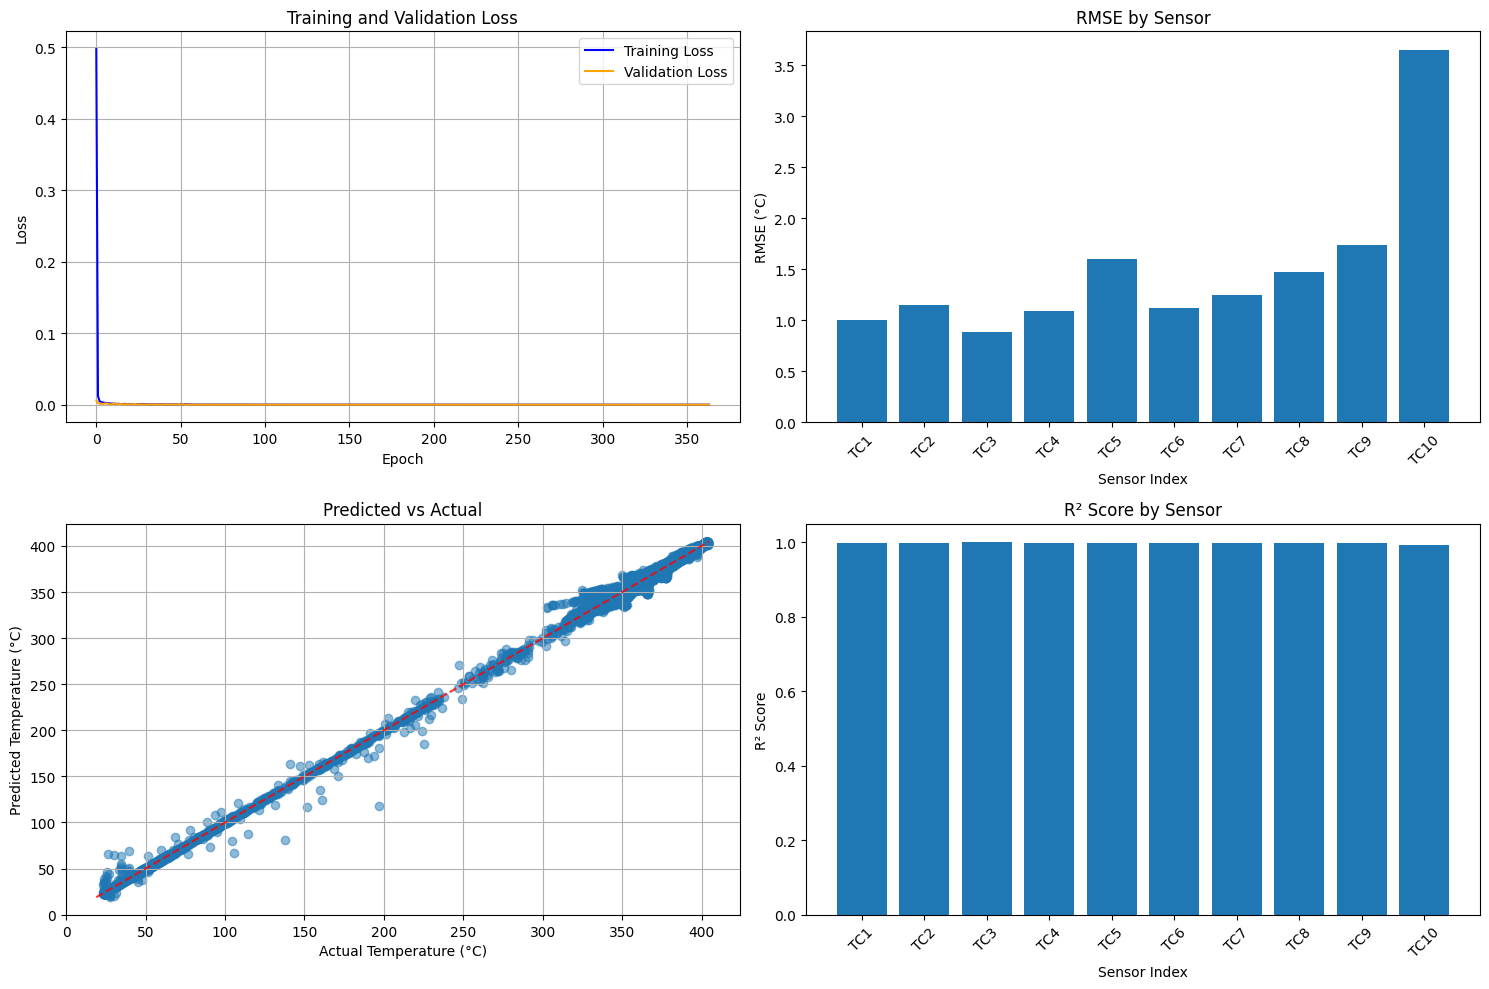

In [20]:
# Block 9: Main Execution
def main():
    """Main execution function"""
    try:
        # Load data (with h6 filter like in your original code)
        DATA_DIR=get_data_directory()
        data = load_data(DATA_DIR, h_filter=h_map[6])  # Only h6 = 0.1575
        
        # Preprocess data
        train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols = preprocess_data(
            data, use_enhanced_features=True
        )
        
        # Create model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        model = EnhancedThermalNet(
            input_size=train_loader.dataset.tensors[0].shape[1],
            output_size=train_loader.dataset.tensors[1].shape[1],
            hidden_dims=[512, 256, 256, 128],
            dropout_rate=0.2
        ).to(device)
        
        print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
        
        # Train model
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, device, epochs=1000, patience=50
        )
        
        # Evaluate model
        results = evaluate_model(model, test_loader, y_scaler, device)
        
        # Print results
        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'MAPE (%)':<12} {'R² Score':<12}")
        print("-"*65)
        
        for i, col in enumerate(tc_cols):
            print(f"{col:<15} {results['rmse'][i]:<12.3f} {results['mae'][i]:<12.3f} "
                  f"{results['mape'][i]:<12.2f} {results['r2'][i]:<12.3f}")
        
        print("-"*65)
        print(f"{'Overall':<15} {results['overall_rmse']:<12.3f} {results['overall_mae']:<12.3f} "
              f"{np.mean(results['mape']):<12.2f} {results['overall_r2']:<12.3f}")

        # Plot results
        plot_results(train_losses, val_losses, results, tc_cols)
        # return model, results, test_results, X_scaler, y_scaler, tc_cols, test_loader, device
        return model, results, X_scaler, y_scaler, tc_cols
                
    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None

if __name__ == "__main__":
    model, results, X_scaler, y_scaler, tc_cols = main()
    # model, results, test_results, X_scaler, y_scaler, tc_cols, test_loader, device = main()

In [21]:
# Block 10: Standalone Prediction Functionality
def load_for_prediction():
    """Load all components needed for prediction"""
    try:
        # Load scalers and metadata
        X_scaler = joblib.load("X_scaler_enhanced.pkl")
        y_scaler = joblib.load("y_scaler_enhanced.pkl")
        time_range_data = joblib.load("time_range_enhanced.pkl")
        column_info = joblib.load("column_info.pkl")
        
        # Set device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load model
        model = EnhancedThermalNet(
            input_size=len(column_info['feature_cols']),
            output_size=len(column_info['tc_cols']),
            hidden_dims=[512, 256, 256, 128],
            dropout_rate=0.2
        ).to(device)
        
        checkpoint = torch.load('best_thermal_model_enhanced.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        print("Prediction components loaded successfully!")
        return model, X_scaler, y_scaler, time_range_data, column_info, device
    
    except Exception as e:
        print(f"Error loading prediction components: {e}")
        return None, None, None, None, None, None

def make_prediction(time, h, flux, abs_val, surf, theoretical_temps):
    """
    Make a temperature prediction with given parameters
    
    Args:
        time: Time value in seconds
        h: Heat transfer coefficient (0.0375, 0.084, or 0.1575)
        flux: Heat flux (19400, 21250, or 25900)
        abs_val: Absorption coefficient (3 or 100)
        surf: Surface emissivity (0.76 or 0.98)
        theoretical_temps: List of 10 theoretical temperatures
        
    Returns:
        Dictionary with predicted temperatures for each TC sensor
    """
    # Load components if not already loaded
    if not all(var in globals() for var in ['pred_model', 'pred_X_scaler', 'pred_y_scaler', 
                                           'pred_time_range', 'pred_column_info', 'pred_device']):
        global pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device
        pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device = load_for_prediction()
        if pred_model is None:
            return None
    
    try:
        # Validate inputs
        if len(theoretical_temps) != 10:
            raise ValueError("Exactly 10 theoretical temperatures required")
        
        if h not in [0.0375, 0.084, 0.1575]:
            print(f"Warning: h value {h} not in expected values [0.0375, 0.084, 0.1575]")
            
        if flux not in [19400, 21250, 25900]:
            print(f"Warning: flux value {flux} not in expected values [19400, 21250, 25900]")
            
        if abs_val not in [3, 100]:
            print(f"Warning: abs value {abs_val} not in expected values [3, 100]")
            
        if surf not in [0.76, 0.98]:
            print(f"Warning: surf value {surf} not in expected values [0.76, 0.98]")
        
        # Make prediction
        result = predict_temperature(
            pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info,
            time, h, flux, abs_val, surf, theoretical_temps, pred_device
        )
        
        return result
        
    except Exception as e:
        print(f"Prediction failed: {e}")
        return None

# Example usage (run this block after training once to load components)
pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device = load_for_prediction()

# Now you can make predictions anytime using:
prediction = make_prediction(
    time=44,
    h=0.1575,
    flux=21250,
    abs_val=3,
    surf=0.98,
    theoretical_temps=[303.991791613348,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606]
    
)
temp_arr=[]
if prediction:
    print("\nPredicted Temperatures:")
    for tc_name, temp in prediction['predicted_temperatures'].items():
        print(f"{tc_name}: {temp:.3f} °C")
        temp_arr.append(temp)

print(temp_arr)

# Test batch inference
        # print("\n3. Testing batch prediction...")
        # try:
        #     if model_inf is not None:
        #         # Create batch of test data
        #         batch_data = [
        #             {
        #                 'time': 1800,  # 30 minutes
        #                 'h': 0.1575,
        #                 'flux': 25900,
        #                 'abs': 100,
        #                 'surf': 0.98,
        #                 'theoretical_temps': [25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0]
        #             },
        #             {
        #                 'time': 3600,  # 60 minutes
        #                 'h': 0.1575,
        #                 'flux': 19400,
        #                 'abs': 3,
        #                 'surf': 0.76,
        #                 'theoretical_temps': [28.0, 32.5, 37.2, 41.8, 46.5, 51.1, 55.8, 60.4, 65.1, 69.7]
        #             }
        #         ]
                
        #         batch_results = batch_predict_temperature(
        #             model_inf, X_scaler_inf, y_scaler_inf, time_range_inf, column_info_inf,
        #             batch_data, device_inf
        #         )
                
        #         print(f"Batch prediction completed for {len(batch_results)} samples")
                
        #         for i, result in enumerate(batch_results):
        #             if result:
        #                 print(f"\nBatch Sample {i+1}:")
        #                 print(f"  Time: {result['input_parameters']['time']/60:.1f} min")
        #                 print(f"  Flux: {result['input_parameters']['flux']}")
        #                 print(f"  Average predicted temp: {np.mean(list(result['predicted_temperatures'].values())):.2f} °C")
                
        #         print("✓ Batch prediction test successful!")
                
        #     else:
        #         print("✗ Batch prediction test failed - model not loaded")
                
        # except Exception as e:
        #     print(f"✗ Batch prediction test failed: {e}")
        

Prediction components loaded successfully!

Predicted Temperatures:
TC1_tip: 361.058 °C
TC2: 359.502 °C
TC3: 360.845 °C
TC4: 360.734 °C
TC5: 360.469 °C
TC6: 362.078 °C
TC7: 360.542 °C
TC8: 361.206 °C
TC9: 358.724 °C
TC10: 338.315 °C
[361.057861328125, 359.50201416015625, 360.8453063964844, 360.733642578125, 360.468505859375, 362.0776062011719, 360.5418395996094, 361.2062683105469, 358.7239990234375, 338.3153076171875]


In [22]:
def plot_vertical_profile(predicted, actual, filename="Sample Profile"):
    # Reverse order so TC10 (surface) is at the top
    predicted = predicted[::-1]
    actual = actual[::-1]
    sensor_labels = [f"TC{i}" for i in range(10, 0, -1)]  # TC10 to TC1

    total_height = 0.1575  # Total receiver height in meters
    spacing = total_height / 9
    depths = [0 - i * spacing for i in range(10)]  # TC10 at 0.0, TC1 at -total_height

    plt.figure(figsize=(7, 6))
    plt.plot(actual, depths, label="Actual", color='blue', marker='o', linewidth=2)
    plt.plot(predicted, depths, label="Predicted", color='red', marker='x', linestyle='--', linewidth=2)

    plt.gca().invert_yaxis()  # So 0 (surface) is at top

    # Set clean numeric y-ticks
    plt.yticks(depths, [f"{d:.3f}" for d in depths])
    plt.ylim(min(depths) - spacing * 0.5, max(depths) + spacing * 0.5)

    plt.xlabel("Temperature (°C)")
    plt.ylabel("Depth (m)")
    plt.title(f"Vertical Profile: {filename}")
    plt.legend(loc='upper right')

    # Add sensor labels next to each point
    for i, label in enumerate(sensor_labels):
        plt.text(
            actual[i], depths[i], label,
            ha='right', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="#cce6ff", ec="navy", lw=1, alpha=0.7)
        )
        plt.text(
            predicted[i], depths[i], label,
            ha='left', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="#ffcccc", ec="darkred", lw=1, alpha=0.7)
        )

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()


# actual = [361.36,360.52,360.93,362.1,361.66,363.36,361.29,361.44,360.32,337.33]
# pred = [361.057861328125, 359.50201416015625, 360.8453063964844, 360.733642578125, 360.468505859375, 362.0776062011719, 360.5418395996094, 361.2062683105469, 358.7239990234375, 338.3153076171875]

# plot_vertical_profile(pred, actual, filename="h6_flux78_abs0_surf0_newSalt_641s")


In [24]:
# Block 11: Standalone Testing
import matplotlib
matplotlib.use('Agg')  # Use non-interactive Agg backend to avoid tkinter dependency
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

def cross_check_test_predictions(data_dir, h_filter=0.1575, num_samples=5, filter_condition=None):
    """Cross-check model predictions with rows from the test dataset."""
    # Load inference components
    global pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device
    if not all(var in globals() for var in ['pred_model', 'pred_X_scaler', 'pred_y_scaler', 
                                           'pred_time_range', 'pred_column_info', 'pred_device']):
        pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device = load_for_prediction()
        if pred_model is None:
            raise ValueError("Failed to load inference components. Ensure model and scalers are saved.")

    # Load and preprocess data to get test_loader
    data = load_data(data_dir, h_filter=h_filter)
    train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols = preprocess_data(data, use_enhanced_features=True)
    
    # Extract test dataset from test_loader
    X_test_scaled = np.concatenate([batch[0].numpy() for batch in test_loader], axis=0)
    y_test_scaled = np.concatenate([batch[1].numpy() for batch in test_loader], axis=0)
    
    # Inverse transform to get original feature and target values
    X_test = pred_X_scaler.inverse_transform(X_test_scaled)
    y_test = pred_y_scaler.inverse_transform(y_test_scaled)
    
    # Create DataFrame for test data
    feature_cols = pred_column_info['feature_cols']
    test_df = pd.DataFrame(X_test, columns=feature_cols)
    test_df[tc_cols] = y_test
    
    # Add original 'Time' (before normalization) for filtering
    time_min = pred_time_range['time_min']
    time_max = pred_time_range['time_max']
    test_df['Time'] = test_df['Time_norm'] * (time_max - time_min) + time_min
    
    # Apply filter condition if provided (e.g., specific time or flux)
    if filter_condition is not None:
        test_df = test_df.query(filter_condition)
        if test_df.empty:
            raise ValueError(f"No test rows match the condition: {filter_condition}")
    
    # Sample rows for cross-checking (no random_state for true randomness)
    num_samples = min(num_samples, len(test_df))
    if num_samples == 0:
        raise ValueError("No test samples available after filtering!")
    sample_rows = test_df.sample(n=num_samples,random_state=33) if filter_condition is None else test_df.head(num_samples)
    
    print(f"\n=== Cross-Checking {len(sample_rows)} Test Samples ===")
    results = []
    
    for idx, row in sample_rows.iterrows():
        # Prepare input features
        time = row['Time']
        h = row['h']
        flux = row['flux']
        abs_val = row['abs']
        surf = row['surf']
        theoretical_temps = [row[col] for col in [c for c in feature_cols if c.startswith('Theoretical_Temps_')]]
        
        # Make prediction
        try:
            pred_result = predict_temperature(
                pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info,
                time, h, flux, abs_val, surf, theoretical_temps, pred_device
            )
            
            # Get actual temperatures
            actual_temps = {col: row[col] for col in tc_cols}
            
            # Compare predictions with actuals
            comparison = {
                'index': idx,
                'inputs': {
                    'time': time,
                    'h': h,
                    'flux': flux,
                    'abs': abs_val,
                    'surf': surf,
                    'theoretical_temps': theoretical_temps
                },
                'predicted_temps': pred_result['predicted_temperatures'],
                'actual_temps': actual_temps,
                'errors': {col: abs(pred_result['predicted_temperatures'][col] - actual_temps[col]) 
                          for col in tc_cols}
            }
            
            results.append(comparison)
            
            # Print comparison
            print(f"\nTest Sample {idx}:")
            print(f"Inputs: Time={time:.2f}s, h={h:.4f}, flux={flux:.0f}, abs={abs_val:.0f}, surf={surf:.2f}")
            print("Theoretical Temps:", [f"{t:.2f}" for t in theoretical_temps])
            print("Predicted vs Actual Temperatures:")
            print("-" * 50)
            print(f"{'Sensor':<15} {'Predicted (°C)':<15} {'Actual (°C)':<15} {'Error (°C)':<15}")
            print("-" * 50)
            for col in tc_cols:
                pred_temp = pred_result['predicted_temperatures'][col]
                actual_temp = actual_temps[col]
                error = comparison['errors'][col]
                print(f"{col:<15} {pred_temp:<15.3f} {actual_temp:<15.3f} {error:<15.3f}")
            
        except Exception as e:
            print(f"Error processing test sample {idx}: {e}")
    
    # Calculate average errors
    if results:
        avg_errors = {col: np.mean([r['errors'][col] for r in results]) for col in tc_cols}
        print("\n=== Average Errors (Test Set) ===")
        print(f"{'Sensor':<15} {'Avg Error (°C)':<15}")
        print("-" * 30)
        for col, avg_error in avg_errors.items():
            print(f"{col:<15} {avg_error:<15.3f}")
    
    return results

def run_test_cross_check(data_dir, h_filter=0.1575, num_samples=5, filter_condition=None):
    """Run cross-checking on test data without requiring main execution."""
    try:
        print("\n=== Running Standalone Test Cross-Check ===")
        results = cross_check_test_predictions(data_dir, h_filter, num_samples, filter_condition)
        
        # Plot results using plot_vertical_profile
        for result in results:
            # Extract predicted and actual temperatures in order TC1_tip to TC10
            tc_cols = ['TC1_tip', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6', 'TC7', 'TC8', 'TC9', 'TC10']
            predicted = [result['predicted_temps'][col] for col in tc_cols]
            actual = [result['actual_temps'][col] for col in tc_cols]
            # Create filename based on input conditions
            filename = (
                f"h{h_filter}_flux{result['inputs']['flux']}_"
                f"abs{result['inputs']['abs']}_surf{result['inputs']['surf']}_"
                f"time{result['inputs']['time']:.0f}s"
            )
            try:
                plot_vertical_profile(predicted, actual, filename=f"Sample {result['index']} - {filename}")
                print(f"Plot saved: {filename}.png")
            except Exception as e:
                print(f"Error plotting sample {result['index']}: {e}")
        
        # Save results to CSV
        # pd.DataFrame(results).to_csv('test_cross_check_results.csv')
        # print("Results saved to 'test_cross_check_results.csv'")
        
        return results
    
    except Exception as e:
        print(f"Error in standalone test cross-check: {e}")
        return None

# Example usage
if __name__ == "__main__":
    DATA_DIR = get_data_directory()
    run_test_cross_check(DATA_DIR, h_filter=0.1575, num_samples=20)

Found data directory: data/new_processed_reset

=== Running Standalone Test Cross-Check ===
Loading data from: data/new_processed_reset
Loaded: cleaned_h6_flux88_abs20_surf0_699s - Sheet1_processed.csv (717 rows)
Skipping (not h=0.1575): cleaned_h2_flux88_abs92_wr_surf0_215s - Sheet1_processed.csv
Loaded: cleaned_h6_flux88_abs0_mr_surf0_617s - Sheet1_processed.csv (532 rows)
Skipping (not h=0.1575): cleaned_h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv
Skipping (not h=0.1575): cleaned_h3_flux88_abs25_mr_surf0_796s-Sheet1_processed.csv
Loaded: cleaned_h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv (4621 rows)
Loaded: cleaned_h6_flux73_abs0_surf1_754s - Sheet3_processed.csv (566 rows)
Loaded: cleaned_h6_flux88_abs92_surf0_648s - Sheet3_processed.csv (621 rows)
Loaded: cleaned_h6_flux88_abs92_surf0_630s - Sheet2_processed.csv (618 rows)
Loaded: cleaned_h6_flux88_abs92_wr_surf0 _835s- Sheet1_processed.csv (516 rows)
Loaded: cleaned_h6_flux88_abs20_surf1_675s - Sheet3_